In [3]:
import os
import numpy as np
import pandas as pd
from skimage.util import montage
from sklearn.model_selection import train_test_split

In [4]:
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ship_dir = '../Proj/airbus-ship-detection' # previously: '/Downloads/airbus-ship-detection/'
train_image_dir = os.path.join(ship_dir, 'train_v2')
test_image_dir = os.path.join(ship_dir, 'test_v2')

In [7]:
masks = pd.read_csv('../Proj/airbus-ship-detection/train_ship_segmentations_v2.csv') # /Users/mbouchou/Downloads/airbus-ship-detection/train_ship_segmentations_v2.csv
not_empty = pd.notna(masks.EncodedPixels)
print(not_empty.sum(), 'masks in', masks[not_empty].ImageId.nunique(), 'images')
print((~not_empty).sum(), 'empty images in', masks.ImageId.nunique(), 'total images')
masks.head()

81723 masks in 42556 images
150000 empty images in 192556 total images


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [8]:
# home = os.path.expanduser("~")
# train_image_dir = os.path.join(home, "Downloads", "airbus-ship-detection", "train_v2")

print(train_image_dir)
print(os.path.isdir(train_image_dir)) # doit afficher True

../Proj/airbus-ship-detection\train_v2
True


,ImageId,ships,has_ship,file_size_kb
58953,4e97bd98b.jpg,0,0.0,88.781250
70492,5dc8066b4.jpg,9,1.0,117.873047
91620,79b1706ba.jpg,1,1.0,104.126953
156392,d0133ba1e.jpg,0,0.0,144.887695
169983,e21391077.jpg,0,0.0,115.719727
187069,f8ccc1c1b.jpg,1,1.0,51.760742
184830,f5c7b87a9.jpg,0,0.0,121.420898


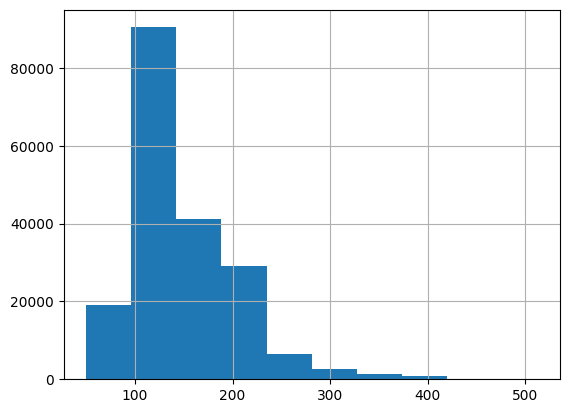

In [9]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)

# some files are too small/corrupt
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(
    lambda c_img_id: os.stat(os.path.join(train_image_dir,c_img_id)).st_size/1024
)

unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb'] > 50] # keep only +50kb files
unique_img_ids['file_size_kb'].hist()
masks.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(7)

In [10]:
print(masks)

              ImageId                                      EncodedPixels
0       00003e153.jpg                                                NaN
1       0001124c7.jpg                                                NaN
2       000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3       000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4       000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
...               ...                                                ...
231718  fffedbb6b.jpg                                                NaN
231719  ffff2aa57.jpg                                                NaN
231720  ffff6e525.jpg                                                NaN
231721  ffffc50b4.jpg                                                NaN
231722  ffffe97f3.jpg                                                NaN

[231723 rows x 2 columns]


### Examine Number of Ship Images
Here we examine how often ships appear and replace the ones without any ships with 0

In [11]:
masks.to_csv("masks.csv", index=False)

<Axes: >

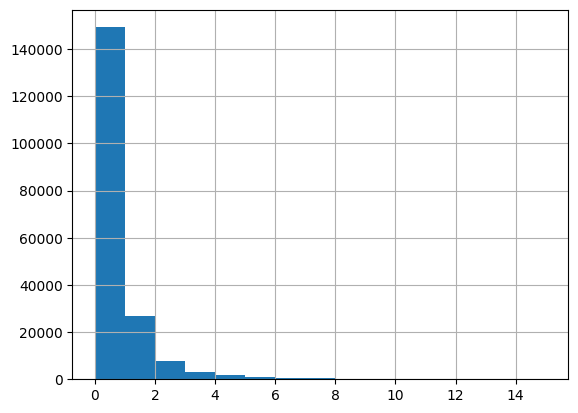

In [12]:
unique_img_ids['ships'].hist(bins=unique_img_ids['ships'].max())

# Undersample Empty Images
Here we undersample the empty images to get a better balanced group with more ships to try and segment

C:\Users\sarro\AppData\Local\Temp\ipykernel_24676\2655675870.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_train_df = unique_img_ids.groupby('ships').apply(


12788 masks


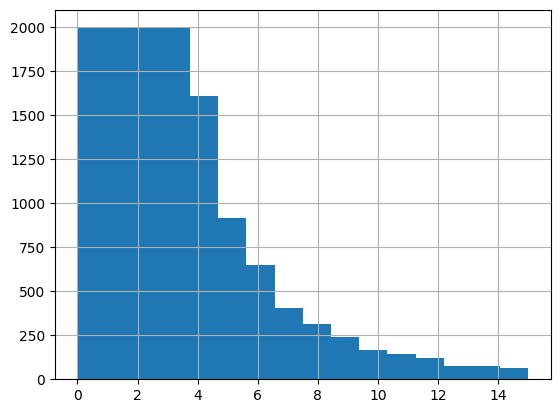

In [13]:
SAMPLES_PER_GROUP = 2000
balanced_train_df = unique_img_ids.groupby('ships').apply(
    lambda x: x.sample(SAMPLES_PER_GROUP) if len(x) > SAMPLES_PER_GROUP else x
)
balanced_train_df['ships'].hist(bins=balanced_train_df['ships'].max()+1)
print(balanced_train_df.shape[0], 'masks')

In [14]:
balanced_train_df = balanced_train_df.reset_index(drop=True)

In [15]:
used_ids = balanced_train_df["ImageId"].unique()
masks_subset = masks[masks["ImageId"].isin(used_ids)].copy()
print(masks_subset.shape)

(44202, 2)


In [16]:
cols_to_keep = ["ImageId", "EncodedPixels"]
masks_clean = masks_subset[cols_to_keep].copy()
masks_clean.reset_index(drop=True, inplace=True)
print(masks_clean.head())
print(masks_clean.shape)

         ImageId                                      EncodedPixels
0  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
1  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
2  000194a2d.jpg  198320 10 199088 10 199856 10 200624 10 201392...
3  000194a2d.jpg  55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
4  000194a2d.jpg  254389 9 255157 17 255925 17 256693 17 257461 ...
(44202, 2)


In [17]:
masks_clean.to_csv("masks_subset.csv", index=False)

In [18]:
train_ids, valid_ids = train_test_split(
    balanced_train_df,
    test_size=0.2,
    stratify=balanced_train_df["ships"],
    random_state=42
)

balanced_train_df["split"] = "train"
balanced_train_df.loc[
    balanced_train_df["ImageId"].isin(valid_ids["ImageId"]), 
    "split"
] = "valid"

In [19]:
balanced_train_df.to_parquet("balanced_train_df.parquet", engine="fastparquet", index=False)

### Save the preprocessed images

In [20]:
import os
import shutil


base_image_dir = "../Proj/airbus-ship-detection/train_v2" # '/Downloads/airbus-ship-detection/train_v2'
train_img_dir = "../Proj/train_img_dir" # or however you prefer to place them and call them
val_img_dir = "../Proj/val_img_dir"

# Create directories
os.makedirs(train_img_dir, exist_ok=True)
os.makedirs(val_img_dir, exist_ok=True)

# Train
for img_name in train_ids["ImageId"]:
    src_path = os.path.join(base_image_dir, img_name)
    if os.path.isfile(src_path):
        shutil.copy2(src_path, os.path.join(train_img_dir, img_name))

# Validation
for img_name in valid_ids["ImageId"]:
    src_path = os.path.join(base_image_dir, img_name)
    if os.path.isfile(src_path):
        shutil.copy2(src_path, os.path.join(val_img_dir, img_name))